# A Restaurant in Toronto

In [171]:
import numpy as np
import pandas as pd
from bs4 import BeautifulSoup
import requests
import re
from matplotlib import pyplot as py
import seaborn as sns
from matplotlib import cm

from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

## create the dataframe

Use beautifulsoup to do it, and then store the data into 3 lisis, finally use pandas to create the dataframe.

**In this part I use the re library to handle the data**

In [3]:
#I copied the code and pasted it into a local text named canada.html
soup=BeautifulSoup(open('canada.html'),features='html.parser')

In [4]:
#create 3 list
PostalCode=[]
Borough=[]
Neighborhood=[]


In [5]:
for items in soup.find('table').find_all('tr'): # item是一行
    item=items.find_all('td')
    for i in range(len(item)):  #遍历一行的元素
        ##print(item[i].text) #处理每一行第一个元素
        stritem=(str(item[i].text))[1:-1]  #把第一个空格去掉
        PostalCode.append(stritem[0:3])                ##这个是（1）str
        strre=stritem[3:-1] # 去掉前三个元素
        #print(strre)
        if strre=='Not assigned':
            Borough.append('Not assigned')
            Neighborhood.append('Not assigned')
        else:
            try:                                   #使用try防止有不带括号的
                res=re.compile(r'(.*?)[(]', re.S)
                A=(re.findall(res,strre))[0]  #A是Borough(2)str
                Borough.append(A)
                res2=re.compile(r'[()](.*?)[)]', re.S)
                B=(re.findall(res2,strre))[0]  #B是Neibor (3)str
                B=B.replace(' / ',',')   #将B转换为，分割
                Neighborhood.append(B)
            except IndexError: #无neibor
                A=strre
                Borough.append(A)
                B=A
                Neighborhood.append(B)


In [6]:
df=pd.DataFrame({'PostalCode':PostalCode,'Borough':Borough,'Neighborhood':Neighborhood})
df.head()

,PostalCode,Borough,Neighborhood
0,M1A,Not assigned,Not assigned
1,M2A,Not assigned,Not assigned
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,"Regent Park,Harbourfront"


## Drop the rows with "Not assigned" Borough

In [7]:
df=df[df['Borough']!='Not assigned']
df.head()

,PostalCode,Borough,Neighborhood
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,"Regent Park,Harbourfront"
5,M6A,North York,"Lawrence Manor,Lawrence Heights"
6,M7A,Queen's Park / Ontario Provincial Government,Queen's Park / Ontario Provincial Government


In [8]:
df.shape

(103, 3)

**we can select the columns as we saw in the homework sample**

In [9]:
column_names = ["PostalCode", "Borough", "Neighborhood"]
dft = pd.DataFrame(columns=column_names)

post_list = ["M5G", "M2H", "M4B", "M1J", "M4G", "M4M", "M1R", "M9V", "M9L", "M5V", "M1B", "M5A"]

for postcode in post_list:
    dft = dft.append(df[df["PostalCode"]==postcode], ignore_index=True)
dft

,PostalCode,Borough,Neighborhood
0,M5G,Downtown Toronto,Central Bay Street
1,M2H,North York,Hillcrest Village
2,M4B,East York,"Parkview Hill,Woodbine Gardens"
3,M1J,Scarborough,Scarborough Village
4,M4G,East York,Leaside
5,M4M,East Toronto,Studio District
6,M1R,Scarborough,"Wexford,Maryvale"
7,M9V,Etobicoke,"South Steeles,Silverstone,Humbergate,Jamestown..."
8,M9L,North York,Humber Summit
9,M5V,Downtown Toronto,"CN Tower,King and Spadina,Railway Lands,Harbou..."


## add the position information

for the connection reason, I've downloaded the csv document 

In [10]:
dflocation=pd.read_csv('Geospatial_Coordinates.csv')

we can use the loop to make it matched between our 2 dataframes

In [11]:
Latitude=[]
Longitude=[]

for i in range(103):
    for j in range(103):
        if df.iat[i,0] ==dflocation.iat[j,0]:    #loop to find the match position
            Latitude.append(dflocation.iat[j,1])
            Longitude.append(dflocation.iat[j,2])

In [12]:
df['Latitude']=Latitude
df['Longitude']=Longitude
df.head()

,PostalCode,Borough,Neighborhood,Latitude,Longitude
2,M3A,North York,Parkwoods,43.753259,-79.329656
3,M4A,North York,Victoria Village,43.725882,-79.315572
4,M5A,Downtown Toronto,"Regent Park,Harbourfront",43.654260,-79.360636
5,M6A,North York,"Lawrence Manor,Lawrence Heights",43.718518,-79.464763
6,M7A,Queen's Park / Ontario Provincial Government,Queen's Park / Ontario Provincial Government,43.662301,-79.389494


**since the order is not the same as what we saw in our homework sample, I created a test dataframe to see if the data is right** 

In [13]:
column_names = ["PostalCode", "Borough", "Neighborhood","Latitude","Longitude"]
dft = pd.DataFrame(columns=column_names)

post_list = ["M5G", "M2H", "M4B", "M1J", "M4G", "M4M", "M1R", "M9V", "M9L", "M5V", "M1B", "M5A"]

for postcode in post_list:
    dft = dft.append(df[df["PostalCode"]==postcode], ignore_index=True)
dft

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M5G,Downtown Toronto,Central Bay Street,43.657952,-79.387383
1,M2H,North York,Hillcrest Village,43.803762,-79.363452
2,M4B,East York,"Parkview Hill,Woodbine Gardens",43.706397,-79.309937
3,M1J,Scarborough,Scarborough Village,43.744734,-79.239476
4,M4G,East York,Leaside,43.709060,-79.363452
5,M4M,East Toronto,Studio District,43.659526,-79.340923
6,M1R,Scarborough,"Wexford,Maryvale",43.750072,-79.295849
7,M9V,Etobicoke,"South Steeles,Silverstone,Humbergate,Jamestown...",43.739416,-79.588437
8,M9L,North York,Humber Summit,43.756303,-79.565963
9,M5V,Downtown Toronto,"CN Tower,King and Spadina,Railway Lands,Harbou...",43.628947,-79.394420


## map visualization

In [14]:
print('The dataframe has {} boroughs and {} neighborhoods.'.format(
        len(df['Borough'].unique()),
        df.shape[0]
    )
)

The dataframe has 15 boroughs and 103 neighborhoods.


get the location of Toronto

In [15]:
address = 'Toronto'
from geopy.geocoders import Nominatim
from geopy.exc import GeocoderTimedOut

geolocator = Nominatim(user_agent="ny_explorer")
def do_geocode(address):
    geopy = Nominatim()
    try:
        return geolocator.geocode(address)
    except GeocoderTimedOut:
        return do_geocode(address)
location = do_geocode(address)


latitude = location.latitude
longitude = location.longitude
print(str(latitude)+'...'+str(longitude))

C:\Users\Administrator\AppData\Roaming\Python\Python36\site-packages\ipykernel_launcher.py:7: DeprecationWarning: Using Nominatim with the default "geopy/1.21.0" `user_agent` is strongly discouraged, as it violates Nominatim's ToS https://operations.osmfoundation.org/policies/nominatim/ and may possibly cause 403 and 429 HTTP errors. Please specify a custom `user_agent` with `Nominatim(user_agent="my-application")` or by overriding the default `user_agent`: `geopy.geocoders.options.default_user_agent = "my-application"`. In geopy 2.0 this will become an exception.
  import sys


43.653963...-79.387207


### create the map

In [16]:
# create map of canada Toronto neighbor using latitude and longitude values
Toronto_map = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(df['Latitude'], df['Longitude'], df['Borough'], df['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(Toronto_map)  
    
Toronto_map



In [37]:
#做出每个Neighborhood的柱状图判断人口稠密程度
df_counts=df['Borough'].value_counts()
Boroughlist=list(df_counts.index)
neighbor_numlist=[]
for i in Boroughlist:
    neighbor_numlist.append(len((df[df['Borough']==i])['Neighborhood'].unique()))
    
neighbor_numarray=np.array(neighbor_numlist)
Borough_numlist=[]
for i in range(len(df_counts)):
    Borough_numlist.append(df_counts[i])
Borough_numarray=np.array(Borough_numlist)
Borough_total_num_list=neighbor_numarray*Borough_numarray
Borough_total_num_list=Borough_total_num_list.tolist()
Borough_total_num_list

[456, 289, 289, 121, 81, 36, 25, 16, 16, 1, 1, 1, 1, 1, 1]

## population density

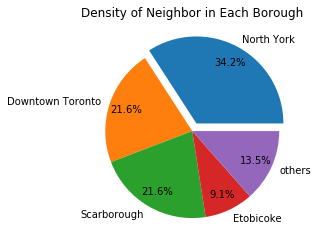

In [42]:
Boroughlist_new=[]
Borough_total_num_list_new=[]
for i in range(4):
    Boroughlist_new.append(Boroughlist[i])
Boroughlist_new.append('others')
for i in range(4):
    Borough_total_num_list_new.append(Borough_total_num_list[i])
othernum=0
for i in range(4,15):
    othernum=othernum+Borough_total_num_list[i]
Borough_total_num_list_new.append(othernum)
#绘制饼图
data1 = Borough_total_num_list_new
labels = Boroughlist_new
explode = [0.1,0,0,0,0]     # 凸显大专人群
py.axes(aspect='equal')    # 将横纵坐标标准化处理,使得饼图是正圆不是椭圆
py.pie(
    x=data1,
    explode=explode,
    labels=labels,
    autopct='%.1f%%',
    pctdistance=0.8,     # 设置百分比数据与圆心的距离
    labeldistance=1.1,    # 设置标签和圆心距离
    textprops = {'fontsize':10,"color":"black"}
)

py.title("Density of Neighbor in Each Borough")
py.show()

**as we can see, a lot people live in North York. So we can observe this area in more detail**

In [220]:
NY_data = df[df['Borough'] == 'North York'].reset_index(drop=True) #得到一个符合条件的新表
NY_data.head()
NY_data_origin=NY_data
NY_data_origin.head()

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M6A,North York,"Lawrence Manor,Lawrence Heights",43.718518,-79.464763
3,M3B,North York,Don Mills,43.745906,-79.352188
4,M6B,North York,Glencairn,43.709577,-79.445073


Let's get the geographical coordinates of North York

In [45]:
address = 'North York'
geolocator = Nominatim(user_agent="ny_explorer")

def do_geocode(address):
    geopy = Nominatim()
    try:
        return geolocator.geocode(address)
    except GeocoderTimedOut:
        return do_geocode(address)
location = do_geocode(address)

latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Manhattan are {}, {}.'.format(latitude, longitude))

C:\Users\Administrator\AppData\Roaming\Python\Python36\site-packages\ipykernel_launcher.py:5: DeprecationWarning: Using Nominatim with the default "geopy/1.21.0" `user_agent` is strongly discouraged, as it violates Nominatim's ToS https://operations.osmfoundation.org/policies/nominatim/ and may possibly cause 403 and 429 HTTP errors. Please specify a custom `user_agent` with `Nominatim(user_agent="my-application")` or by overriding the default `user_agent`: `geopy.geocoders.options.default_user_agent = "my-application"`. In geopy 2.0 this will become an exception.
  """


The geograpical coordinate of Manhattan are 43.7543263, -79.44911696639593.


In [188]:
# create map of Downtown Toronto using latitude and longitude values
NY_map1 = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, label in zip(Downtown_data['Latitude'], Downtown_data['Longitude'], Downtown_data['Neighborhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(NY_map1)  
    
NY_map1

Though we all know that in the downtown the population may be more densy, we just culculate the total neighbors in this part to choose a position, since we don't have the area squre information.


In [49]:
NY_data.mean()  #找到区域中心点

Latitude     43.750727
Longitude   -79.429338
dtype: float64

now we  are going to visulize the distribuition of the neighbors

Text(0.5, 1, 'NY_jointplot')

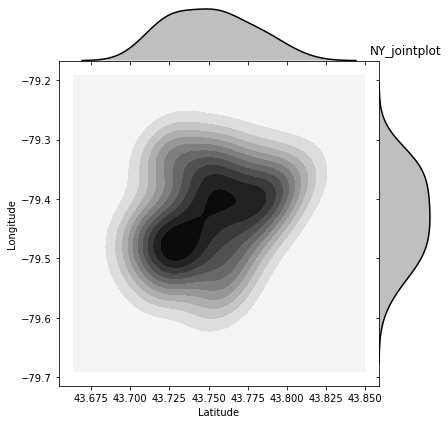

In [56]:
NY_jointplot=sns.jointplot("Latitude","Longitude",data=NY_data,kind="kde",space=0,ratio=6,color="k")
py.title('NY_jointplot')

## cluster the positions with KMeans

we may as well desprate the area into 2 clusters

In [67]:
loc=np.array(NY_data[['Latitude','Longitude']])
loc_cluster=KMeans(n_clusters=2)
loc_cluster=loc_cluster.fit(loc)
loc_cluster.cluster_centers_

array([[ 43.74121507, -79.48819163],
       [ 43.76023978, -79.37048502]])

In [70]:
NY_data['label']=loc_cluster.labels_
NY_data

,PostalCode,Borough,Neighborhood,Latitude,Longitude,label
0,M3A,North York,Parkwoods,43.753259,-79.329656,1
1,M4A,North York,Victoria Village,43.725882,-79.315572,1
2,M6A,North York,"Lawrence Manor,Lawrence Heights",43.718518,-79.464763,0
3,M3B,North York,Don Mills,43.745906,-79.352188,1
4,M6B,North York,Glencairn,43.709577,-79.445073,0
5,M3C,North York,Don Mills,43.725900,-79.340923,1
6,M2H,North York,Hillcrest Village,43.803762,-79.363452,1
7,M3H,North York,"Bathurst Manor,Wilson Heights,Downsview North",43.754328,-79.442259,0
8,M2J,North York,"Fairview,Henry Farm,Oriole",43.778517,-79.346556,1
9,M3J,North York,"Northwood Park,York University",43.767980,-79.487262,0


In [74]:
NY_data0=NY_data[NY_data['label']==0].reset_index(drop=True)
NY_data0=NY_data0[['Latitude','Longitude']]
NY_data1=NY_data[NY_data['label']==1].reset_index(drop=True)
NY_data1=NY_data1[['Latitude','Longitude']]

Text(0.5, 1.0, 'cluster for position in North York')

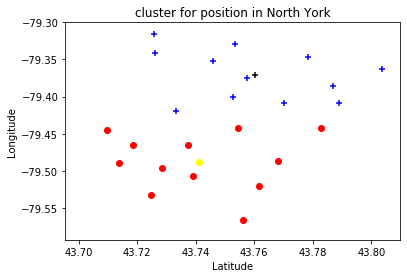

In [84]:
py.scatter(NY_data0['Latitude'],NY_data0['Longitude'],color="red")
py.scatter(NY_data1['Latitude'],NY_data1['Longitude'],color="blue",marker='+')
py.scatter(43.74121507, -79.48819163,color='yellow')
py.scatter(43.76023978, -79.37048502,color='black',marker='+')
py.xlabel('Latitude')
py.ylabel('Longitude')
py.title('cluster for position in North York')

As we can see, the yellow and black are the 2 center points of the position

In [189]:
for lat, lng, label in zip([43.74121507,43.76023978], [-79.48819163,-79.37048502],['center0','center1']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='red',
        fill=True,
        fill_color='red',
        fill_opacity=0.7,
        parse_html=False).add_to(NY_map1)  
    
NY_map1

In [191]:
folium.Circle([43.74121507,-79.48819163]
              , 5000
              ,color='red'
              ,fill_color='red'
              ,fillOpacity=0.5
             ).add_to(NY_map1)
folium.Circle([43.76023978,-79.37048502]
              , 5000
              ,color='red'
              ,fill_color='red'
              ,fillOpacity=0.5
             ).add_to(NY_map1)

NY_map1


## use the API to get the nearby inpormation

note:in this part, for the bad connection in my home, I can just add the dataframe every 5 neighbors

so **lease just ignore this**.

In [86]:
CLIENT_ID = 'JUNLRY3MCR1AE23FFX4ZC4HAGPSDXRETLZ5FJNNX0GJIKF51' # your Foursquare ID
CLIENT_SECRET = 'H1GBVAUYFJ52DJT50FK1GZNK2DW2A1ZOWY32IGLD4BKIGHOQ' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: JUNLRY3MCR1AE23FFX4ZC4HAGPSDXRETLZ5FJNNX0GJIKF51
CLIENT_SECRET:H1GBVAUYFJ52DJT50FK1GZNK2DW2A1ZOWY32IGLD4BKIGHOQ


In [87]:
def getNearbyVenues(names, latitudes, longitudes, radius=500,LIMIT = 100): #limit是自己加上的
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [91]:
NY_data5=NY_data.head()

In [92]:
NY_venues = getNearbyVenues(names=NY_data5['Neighborhood'],
                                   latitudes=NY_data5['Latitude'],
                                   longitudes=NY_data5['Longitude']
                                  )

Parkwoods
Victoria Village
Lawrence Manor,Lawrence Heights
Don Mills
Glencairn


In [101]:
NY_data5=NY_data[5:10]
NY_data5=NY_venues.append(getNearbyVenues(names=NY_data5['Neighborhood'],
                                   latitudes=NY_data5['Latitude'],
                                   longitudes=NY_data5['Longitude']
                                  ))

Don Mills
Hillcrest Village
Bathurst Manor,Wilson Heights,Downsview North
Fairview,Henry Farm,Oriole
Northwood Park,York University


In [103]:
NY_data5=NY_data[10:15]
NY_data5=NY_venues.append(getNearbyVenues(names=NY_data5['Neighborhood'],
                                   latitudes=NY_data5['Latitude'],
                                   longitudes=NY_data5['Longitude']
                                  ))

Bayview Village
Downsview
York Mills,Silver Hills
Downsview
North Park,Maple Leaf Park,Upwood Park


In [104]:
NY_data5=NY_data[15:20]
NY_data5=NY_venues.append(getNearbyVenues(names=NY_data5['Neighborhood'],
                                   latitudes=NY_data5['Latitude'],
                                   longitudes=NY_data5['Longitude']
                                  ))

Humber Summit
Willowdale,Newtonbrook
Downsview
Bedford Park,Lawrence Manor East
Humberlea,Emery


In [105]:
NY_data5=NY_data[20:24]
NY_data5=NY_venues.append(getNearbyVenues(names=NY_data5['Neighborhood'],
                                   latitudes=NY_data5['Latitude'],
                                   longitudes=NY_data5['Longitude']
                                  ))

Willowdale
Downsview
York Mills West
Willowdale


In [106]:
NY_data=NY_data5
NY_data

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Parkwoods,43.753259,-79.329656,Brookbanks Park,43.751976,-79.332140,Park
1,Parkwoods,43.753259,-79.329656,Variety Store,43.751974,-79.333114,Food & Drink Shop
2,Victoria Village,43.725882,-79.315572,Victoria Village Arena,43.723481,-79.315635,Hockey Arena
3,Victoria Village,43.725882,-79.315572,Tim Hortons,43.725517,-79.313103,Coffee Shop
4,Victoria Village,43.725882,-79.315572,Portugril,43.725819,-79.312785,Portuguese Restaurant
...,...,...,...,...,...,...,...
44,Willowdale,43.782736,-79.442259,Dollarama,43.784670,-79.446670,Discount Store
45,Willowdale,43.782736,-79.442259,Tim Hortons,43.780940,-79.444231,Coffee Shop
46,Willowdale,43.782736,-79.442259,Price Chopper,43.783237,-79.446339,Grocery Store
47,Willowdale,43.782736,-79.442259,RBC Royal Bank,43.783894,-79.446603,Bank


In [107]:
NY_data.groupby(['Neighborhood']).count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Don Mills,5,5,5,5,5,5
Downsview,4,4,4,4,4,4
Glencairn,4,4,4,4,4,4
"Lawrence Manor,Lawrence Heights",13,13,13,13,13,13
Parkwoods,2,2,2,2,2,2
Victoria Village,4,4,4,4,4,4
Willowdale,41,41,41,41,41,41
York Mills West,4,4,4,4,4,4


In [129]:
Venue_Category=NY_data['Venue Category'].unique()

## create the **one-hot dataframe** to analyze the destribution of the restaurants.

In [114]:
one_hot=pd.get_dummies(NY_data['Venue Category'])
one_hot['Neighborhood']=NY_data['Neighborhood']
one_hot

,Accessories Store,Arts & Crafts Store,Athletics & Sports,Bank,Baseball Field,Boutique,Bubble Tea Shop,Café,Caribbean Restaurant,Clothing Store,...,Pub,Ramen Restaurant,Restaurant,Sandwich Place,Shoe Store,Shopping Mall,Steakhouse,Sushi Restaurant,Vietnamese Restaurant,Neighborhood
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Parkwoods
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Parkwoods
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Victoria Village
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Victoria Village
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Victoria Village
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Willowdale
45,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Willowdale
46,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Willowdale
47,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Willowdale


In [132]:
Venue_Category
Venue_Category=list(Venue_Category)
Venue_Category

['Park',
 'Food & Drink Shop',
 'Hockey Arena',
 'Coffee Shop',
 'Portuguese Restaurant',
 'Financial or Legal Service',
 'Boutique',
 'Furniture / Home Store',
 'Vietnamese Restaurant',
 'Clothing Store',
 'Accessories Store',
 'Event Space',
 'Miscellaneous Shop',
 'Shoe Store',
 'Gym / Fitness Center',
 'Caribbean Restaurant',
 'Café',
 'Japanese Restaurant',
 'Baseball Field',
 'Sushi Restaurant',
 'Pub',
 'Grocery Store',
 'Ramen Restaurant',
 'Steakhouse',
 'Movie Theater',
 'Indonesian Restaurant',
 'Plaza',
 'Ice Cream Shop',
 'Shopping Mall',
 'Arts & Crafts Store',
 'Juice Bar',
 'Pet Store',
 'Lounge',
 'Restaurant',
 'Sandwich Place',
 'Fast Food Restaurant',
 'Electronics Store',
 'Discount Store',
 'Pizza Place',
 'Middle Eastern Restaurant',
 'Bubble Tea Shop',
 'Hotel',
 'Liquor Store',
 'Athletics & Sports',
 'Bank',
 'Convenience Store',
 'Pharmacy',
 'Home Service']

now we can clean the data and select the restaurants

In [133]:
Venue_Category_new=[]
for i in range(len(Venue_Category)):
    if "Restaurant" in Venue_Category[i]:
        Venue_Category_new.append(Venue_Category[i])
Venue_Category_new

['Portuguese Restaurant',
 'Vietnamese Restaurant',
 'Caribbean Restaurant',
 'Japanese Restaurant',
 'Sushi Restaurant',
 'Ramen Restaurant',
 'Indonesian Restaurant',
 'Restaurant',
 'Fast Food Restaurant',
 'Middle Eastern Restaurant']

## Culculate restaurants in each neighborhood

In [163]:
one_hot_res=one_hot[Venue_Category_new]
one_hot_res['total_res']=one_hot_res.sum(axis=1)
one_hot_res['Neighborhood']=one_hot['Neighborhood']
df_T_N=one_hot_res.drop(Venue_Category_new,axis=1)
df_T_N=df_T_N.groupby('Neighborhood',as_index=False).sum()   #use'as_index=False'
df_T_N
#one_hot_res_group=one_hot_res.groupby(['Neighborhood'])
#one_hot_res_group

C:\Users\Administrator\AppData\Roaming\Python\Python36\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\Administrator\AppData\Roaming\Python\Python36\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,Neighborhood,total_res
0,Don Mills,2
1,Downsview,0
2,Glencairn,2
3,"Lawrence Manor,Lawrence Heights",1
4,Parkwoods,0
5,Victoria Village,1
6,Willowdale,12
7,York Mills West,0


Text(0.5, 1.0, 'Total_res in Neighborhoods')

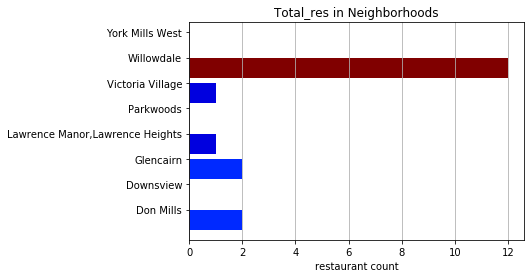

In [174]:
ylabel = list(df_T_N['Neighborhood'])
x = list(df_T_N['total_res'])
idx = np.arange(len(x))
color = cm.jet(np.array(x)/max(x))
py.barh(idx, x, color=color)
py.yticks(idx+0.4,ylabel)
py.grid(axis='x')
py.xlabel('restaurant count')
py.title('Total_res in Neighborhoods')

now, we know the restraunt destribution in the areas. what's more, we are about to try to avoid open our restaurant near the most density areas. 

we can assum that since people are going to eat out, they have the same tendency to eat in each restaurants. In this case, the propability **(P)** of this tendency can be seemed as **1/(res_count+1)**

In [180]:
loc_name=list(df_T_N['Neighborhood'])
loc_name

['Don Mills',
 'Downsview',
 'Glencairn',
 'Lawrence Manor,Lawrence Heights',
 'Parkwoods',
 'Victoria Village',
 'Willowdale',
 'York Mills West']

consider Neibor as the center of venues，use the weight(number of restaurants) to culculate the mean position of neighbors


注：实际上餐厅分布在neighbor venues可以认为是均匀的，因此用平均位置代替此时的位置

In [199]:
Latitudes=[]
Longitudes=[]
for nei in loc_name:
    Latitude=NY_data[NY_data['Neighborhood']==nei]['Neighborhood Latitude'].mean()
    Longitude=NY_data[NY_data['Neighborhood']==nei]['Neighborhood Longitude'].mean()
    Latitudes.append(Latitude)
    Longitudes.append(Longitude)

In [201]:
df_T_N['Latitude']=Latitudes
df_T_N['Longitude']=Longitudes
df_T_N

,Neighborhood,total_res,Latitude,Longitude
0,Don Mills,2,43.745906,-79.352188
1,Downsview,0,43.761631,-79.520999
2,Glencairn,2,43.709577,-79.445073
3,"Lawrence Manor,Lawrence Heights",1,43.718518,-79.464763
4,Parkwoods,0,43.753259,-79.329656
5,Victoria Village,1,43.725882,-79.315572
6,Willowdale,12,43.772274,-79.414258
7,York Mills West,0,43.752758,-79.400049


**1.Take the weighted center point of the restaurant venues to find this**

In [205]:
Laplus=0  #这两个量用来计算位置的加权和
Loplus=0
suml=0 #权重和
total_res=list(df_T_N['total_res'])
for i in range(len(total_res)):
    Laplus=total_res[i]*Latitudes[i]+ Laplus
    Loplus=total_res[i]*Longitudes[i]+Loplus
    suml=suml+total_res[i]
la_mean=Laplus/suml  #平均值
lo_mean=Loplus/suml
print('mean latitude:{},mean longitude:{}'.format(la_mean,lo_mean))

mean latitude:43.75681406327914,mean longitude:-79.40810832479674


**2.Categorize this point**

In [214]:
#聚类函数
def destribute(p,c1,c2):  #p,c1,c2均为点的坐标列表形式   
    r1=(p[0]-c1[0])**2+(p[1]-c1[1])**2  #p,c1的距离
    r2=(p[0]-c2[0])**2+(p[1]-c2[1])**2
    if r1<r2:
        return 'c1'
    else:
        return 'c2'

In [215]:
p=[la_mean,lo_mean]
c1=[43.74121507,-79.48819163]
c2=[43.76023978,-79.37048502]
destribute(p,c1,c2)

'c2'

When the classification is divided into c2, we think that c1 is the best, and make a diagram

In [216]:
NY_map2=NY_map1

folium.CircleMarker(
        [la_mean, lo_mean],
        radius=5,
        color='red',
        fill=True,
        fill_color='yellow',
        fill_opacity=0.7,
        parse_html=False).add_to(NY_map2)  
    
NY_map2

**3.Reinitialize the cluster**

In [291]:
loc2=np.array(NY_data_origin[['Latitude','Longitude']])
c1=[43.74121507,-79.48819163]
c2=[la_mean, lo_mean]
def distance_choice(p,c1,c2):            #用于判断离谁近从而决定往哪个数组放
    r1=(p[0]-c1[0])**2+(p[1]-c1[1])**2  #p,c1的距离
    r2=(p[0]-c2[0])**2+(p[1]-c2[1])**2
    if r1<r2:
        return 1
    else:
        return 0
    
    
def kmeans(plist_array,c1,c2,k):
    for j in range(k):                   #更新次数
        c1s=[]    #两个数组用于储存c1 c2在每次循环中的值
        c2s=[]
        for i in range(loc2.shape[0]):   #过position array
            p=plist_array[i]
            c1=c1
            c2=c2
            if distance_choice(p,c1,c2):
                c1s.append(p)
            else:
                c2s.append(p)
        c1=np.array(c1s).mean(axis=0)
        print(c1)
        c2=np.array(c2s).mean(axis=0)
    return c1,c2,c1s,c2s

In [292]:
c1,c2

([43.74121507, -79.48819163], [43.75681406327914, -79.40810832479674])

In [293]:
c1,c2,c1s,c2s=kmeans(loc2,c1,c2,1)

[ 43.73575162 -79.4973781 ]


In [294]:
c1,c2,c1s,c2s

(array([ 43.73575162, -79.4973781 ]),
 array([ 43.76142443, -79.38073849]),
 [array([ 43.718518 , -79.4647633]),
  array([ 43.709577 , -79.4450726]),
  array([ 43.7679803, -79.4872619]),
  array([ 43.7374732, -79.4647633]),
  array([ 43.7390146, -79.5069436]),
  array([ 43.7137562, -79.4900738]),
  array([ 43.7563033, -79.5659633]),
  array([ 43.7284964, -79.4956974]),
  array([ 43.7247659, -79.5322424]),
  array([ 43.7616313, -79.5209994])],
 [array([ 43.7532586, -79.3296565]),
  array([ 43.7258823, -79.3155716]),
  array([ 43.7459058, -79.352188 ]),
  array([ 43.7258997, -79.340923 ]),
  array([ 43.8037622, -79.3634517]),
  array([ 43.7543283, -79.4422593]),
  array([ 43.7785175, -79.3465557]),
  array([ 43.7869473, -79.385975 ]),
  array([ 43.7574902, -79.3747141]),
  array([ 43.789053 , -79.4084928]),
  array([ 43.7332825, -79.4197497]),
  array([ 43.7701199, -79.4084928]),
  array([ 43.7527583, -79.4000493]),
  array([ 43.7827364, -79.4422593])])

In [300]:
folium.CircleMarker(
        c2,
        radius=5,
        color='green',
        fill=True,
        fill_color='green',
        fill_opacity=0.7,
        parse_html=False).add_to(NY_map2)  
    
NY_map2

In [302]:
folium.CircleMarker(
        c1,
        radius=5,
        color='black',
        fill=True,
        fill_color='black',
        fill_opacity=0.7,
        parse_html=False).add_to(NY_map2)  
    
NY_map2

Both considering the density of population and the destribution of other restaurants, we find the point c1 can fullfill the condition. Thus we can finally get the conclusion that our restaurant can open at c1[ 43.73575162, -79.4973781 ]

In [ ]:
#只用一次循环的原因：找到与c1 c2最近的点，求出新中心点

In [312]:
# create map of Downtown Toronto using latitude and longitude values
NY_map = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, label in zip(Downtown_data['Latitude'], Downtown_data['Longitude'], Downtown_data['Neighborhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(NY_map)  
for lat, lng, label in zip([43.74121507,43.76023978], [-79.48819163,-79.37048502],['center0','center1']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='red',
        fill=True,
        fill_color='red',
        fill_opacity=0.7,
        parse_html=False).add_to(NY_map)  
folium.CircleMarker(
        [la_mean, lo_mean],
        radius=5,
        popup='shopping center',
        color='red',
        fill=True,
        fill_color='yellow',
        fill_opacity=0.7,
        parse_html=False).add_to(NY_map)  
folium.CircleMarker(
        c1,
        radius=5,
        color='black',
        popup='c1--our restaurant',
        fill=True,
        fill_color='black',
        fill_opacity=0.7,
        parse_html=False).add_to(NY_map) 
folium.CircleMarker(
        c2,
        radius=5,
        color='black',
        popup='c2-the other center',
        fill=True,
        fill_color='black',
        fill_opacity=0.7,
        parse_html=False).add_to(NY_map)  
    
NY_map

In [309]:
c1

array([ 43.73575162, -79.4973781 ])